In [1]:
import numpy as np
from pydpmd.data import RigidBumpy, load
from pydpmd.plot import draw_particles_frame, create_animation, downsample
from correlation_functions import compute_msd, compute_shear_modulus, compute_rotational_msd, compute_pair_correlation_function, compute_vacf, compute_rotational_msd
from pydpmd.calc import run_binned, fused_msd_kernel, TimeBins, LagBinsExact, LagBinsLog, LagBinsLinear, LagBinsPseudoLog, requires_fields
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os
import re
from tqdm import tqdm
from scipy.optimize import minimize
def obj_func(b, x, y):
    return np.sum((x + b - y) ** 2)

def get_relaxation_time(f, t):
    tau = np.interp(1 / np.e, f[::-1], t[::-1])
    if not np.min(f) < 1 / np.e:
        return np.nan
    return tau

Loading trajectory: 100%|██████████| 9/9 [00:01<00:00,  4.99it/s]


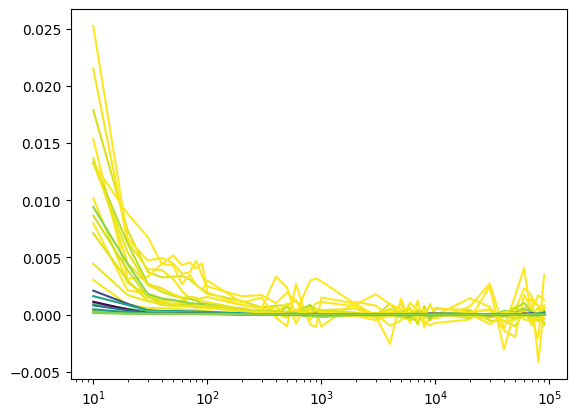

In [11]:
run_dir = '/home/mmccraw/dev/data/10-01-25/calculate-shear-modulus/short-runs/dynamics_0'
data = load(run_dir, location=['final', 'init'], load_trajectory=True, load_full=True)
msd_path = os.path.join(run_dir, "msd.npz")
msd, t = compute_msd(data, msd_path)

shear_modulus_path = os.path.join(run_dir, "shear_modulus.npz")
shear_modulus, t = compute_shear_modulus(data, shear_modulus_path)


phi_norm = plt.Normalize(vmin=data.packing_fraction.min(), vmax=data.packing_fraction.max())
cmap = plt.cm.viridis

for i in range(msd.shape[1]):
#     plt.plot(t, msd[:, i], c=cmap(phi_norm(data.packing_fraction[i])))
#     fit_mask = t > t.max() / 1e2
#     D = 10 ** minimize(obj_func, x0=1, args=(np.log10(t[fit_mask]), np.log10(msd[:, i][fit_mask]))).x[0]
#     plt.plot(t, t * D, c='k', ls='--', alpha=0.5, zorder=0)
#     plt.yscale('log')
    plt.plot(t, shear_modulus[:, i], c=cmap(phi_norm(data.packing_fraction[i])))
plt.xscale('log')
plt.show()

Loading trajectory: 100%|██████████| 9/9 [00:02<00:00,  3.07it/s]


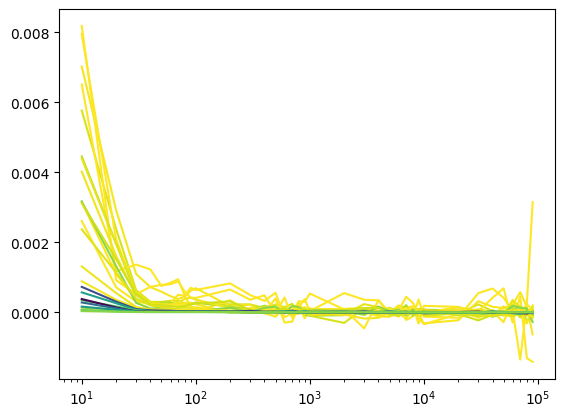

In [3]:
run_dir = '/home/mmccraw/dev/data/10-01-25/calculate-shear-modulus/short-runs-2/dynamics_0'
data = load(run_dir, location=['final', 'init'], load_trajectory=True, load_full=True)
shear_modulus_path = os.path.join(run_dir, "shear_modulus.npz")
shear_modulus, t = compute_shear_modulus(data, shear_modulus_path)

phi_norm = plt.Normalize(vmin=data.packing_fraction.min(), vmax=data.packing_fraction.max())
cmap = plt.cm.viridis

for i in range(shear_modulus.shape[1]):
    plt.plot(t, shear_modulus[:, i], c=cmap(phi_norm(data.packing_fraction[i])))
plt.xscale('log')
plt.show()


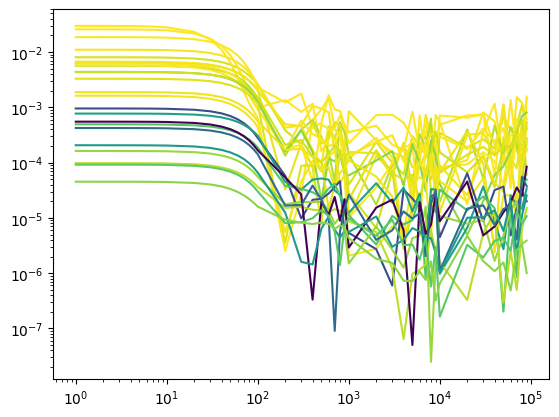

In [ ]:
run_dir = '/home/mmccraw/dev/data/10-01-25/calculate-shear-modulus/short-runs-5/dynamics_0'
data = load(run_dir, location=['final', 'init'], load_trajectory=True, load_full=False)
shear_modulus_path = os.path.join(run_dir, "shear_modulus.npz")
shear_modulus, t = compute_shear_modulus(data, shear_modulus_path)

phi_norm = plt.Normalize(vmin=data.packing_fraction.min(), vmax=data.packing_fraction.max())
cmap = plt.cm.viridis

for i in range(shear_modulus.shape[1]):
    plt.plot(t, np.abs(shear_modulus[:, i]), c=cmap(phi_norm(data.packing_fraction[i])))
plt.xscale('log')
plt.yscale('log')
plt.show()